In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Load data konsumsi listrik dan ubah ke harian
df = pd.read_csv("AEP_hourly.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
daily_df = df['AEP_MW'].resample('D').mean().reset_index()
daily_df.rename(columns={'Datetime': 'Date'}, inplace=True)

In [45]:
holidays = pd.read_csv("US Holiday Dates (2004-2021).csv")
holidays['Date'] = pd.to_datetime(holidays['Date'])

In [46]:
# Lihat semua nama hari libur unik dan berapa kali muncul
print(holidays['Holiday'].value_counts().sort_index())

Holiday
4th of July                    18
Christmas Day                  18
Christmas Eve                  18
Columbus Day                   18
Eastern Easter                 18
Juneteenth                     18
Labor Day                      18
Labor Day Weekend              36
Martin Luther King, Jr. Day    18
Memorial Day                   18
New Year's Day                 18
New Year’s Eve                 18
Thanksgiving Day               18
Thanksgiving Eve               18
Valentine’s Day                18
Veterans Day                   18
Washington's Birthday          18
Western Easter                 18
Name: count, dtype: int64


In [48]:
# Merge data libur ke daily_df
daily_df = daily_df.merge(holidays[['Date', 'Holiday']], on='Date', how='left')

# Buat kolom is_holiday: True kalau ada nama libur
daily_df['is_holiday'] = daily_df['Holiday'].notna()

# Group by Year dan Libur
daily_df['DayOfWeek'] = daily_df['Date'].dt.dayofweek
daily_df['Year'] = daily_df['Date'].dt.year
daily_df['is_weekend'] = daily_df['DayOfWeek'].isin([5, 6])
daily_df['is_effective_holiday'] = daily_df['is_holiday'] | daily_df['is_weekend']

C:\Users\71485\AppData\Local\Temp\ipykernel_11216\2801511293.py:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


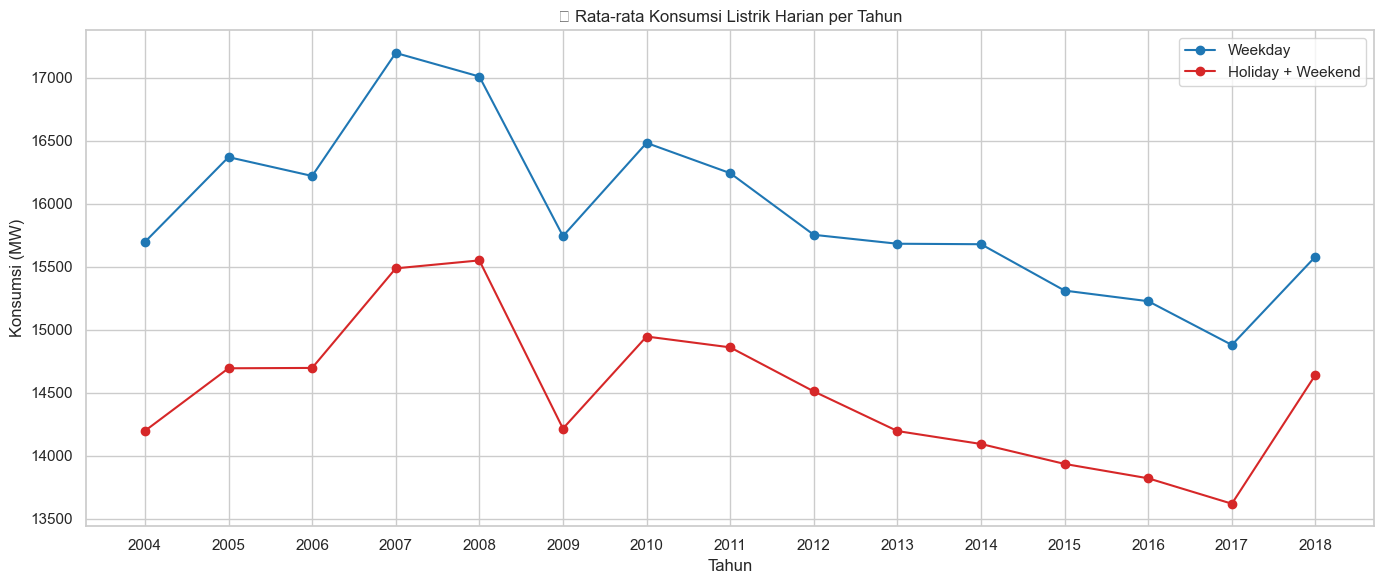

In [76]:
# Hitung rata-rata harian
avg_by_year = daily_df.groupby(['Year', 'is_effective_holiday'])['AEP_MW'].mean().reset_index()

# Pivot ke bentuk Weekday vs Libur
pivot_avg = avg_by_year.pivot(index='Year', columns='is_effective_holiday', values='AEP_MW')
pivot_avg.columns = ['Weekday', 'Holiday+Weekend']  # False = Weekday, True = Libur
pivot_avg['%_Difference'] = 100 * (pivot_avg['Weekday'] - pivot_avg['Holiday+Weekend']) / pivot_avg['Weekday']

# Siapkan tahun sebagai kolom agar bisa dipakai sebagai sumbu X
pivot_avg = pivot_avg.reset_index()  # Sekali aja, ini penting!

# Plot
years = pivot_avg['Year'].tolist()

plt.figure(figsize=(14, 6))
plt.plot(years, pivot_avg['Weekday'], label='Weekday', marker='o', color='tab:blue')
plt.plot(years, pivot_avg['Holiday+Weekend'], label='Holiday + Weekend', marker='o', color='tab:red')

plt.title("📈 Rata-rata Konsumsi Listrik Harian per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Konsumsi (MW)")
plt.xticks(years)  # Tampilkan semua tahun
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\71485\AppData\Local\Temp\ipykernel_11216\3880459161.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()


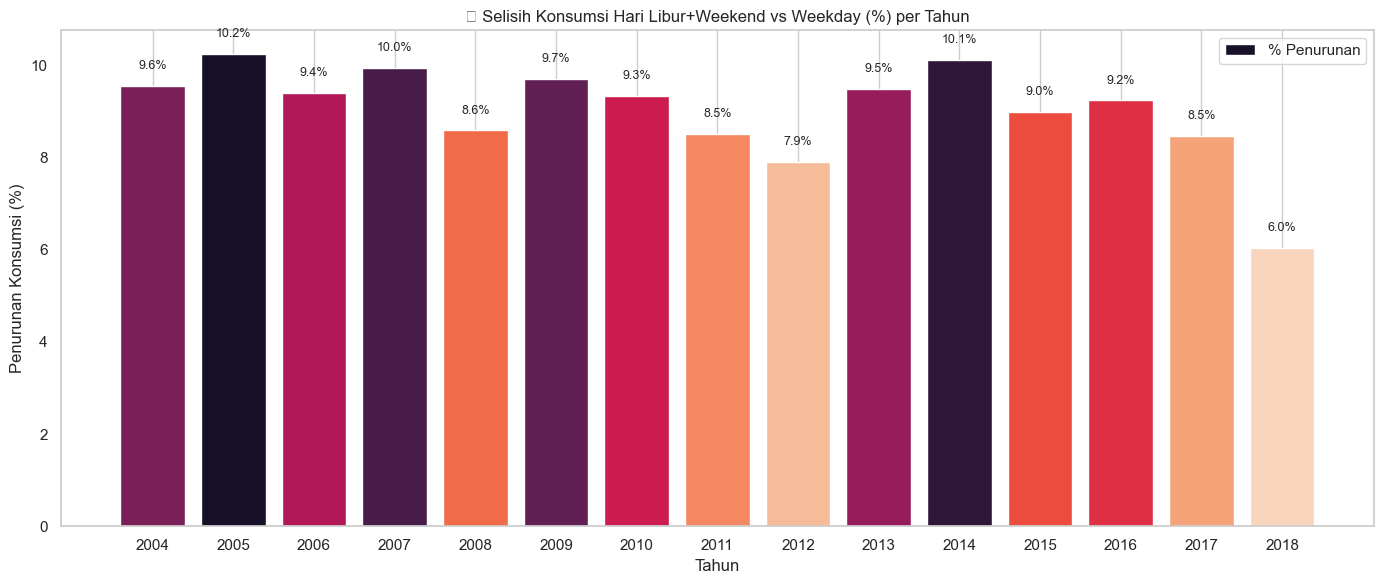

In [73]:
# Urutkan dari yang tertinggi ke terendah
pivot_sorted = pivot_avg.sort_values(by='%_Difference', ascending=False).reset_index(drop=True)

# Ambil tahun & persen
years = pivot_sorted['Year'].tolist()
percents = pivot_sorted['%_Difference'].tolist()

# Buat gradasi warna
colors = sns.color_palette("rocket", len(years))

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(years, percents, color=colors)

# Tambah label angka di atas bar
for bar, year, percent in zip(bars, years, percents):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f"{percent:.1f}%", ha='center', va='bottom', fontsize=9)

plt.title("📊 Selisih Konsumsi Hari Libur+Weekend vs Weekday (%) per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Penurunan Konsumsi (%)")
plt.xticks(years)  # Semua tahun muncul
plt.legend(["% Penurunan"], loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

C:\Users\71485\AppData\Local\Temp\ipykernel_11216\453019568.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Month', y='AEP_MW', data=monthly_avg, palette='rocket')
C:\Users\71485\AppData\Local\Temp\ipykernel_11216\453019568.py:24: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


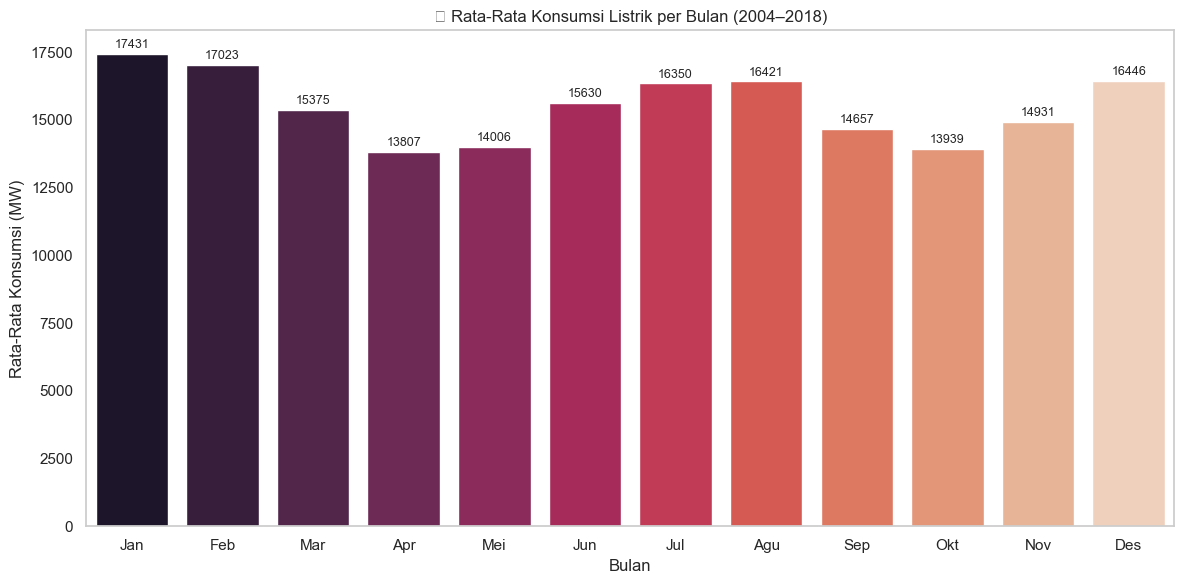

In [77]:
# Tambah kolom bulan
daily_df['Month'] = daily_df['Date'].dt.month

# Hitung rata-rata konsumsi per bulan (gabungan semua tahun)
monthly_avg = daily_df.groupby('Month')['AEP_MW'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
bars = sns.barplot(x='Month', y='AEP_MW', data=monthly_avg, palette='rocket')

# Tambah label angka di atas bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 100,
             f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)

plt.title("📅 Rata-Rata Konsumsi Listrik per Bulan (2004–2018)")
plt.xlabel("Bulan")
plt.ylabel("Rata-Rata Konsumsi (MW)")
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 'Jul', 'Agu', 'Sep', 'Okt', 'Nov', 'Des'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

C:\Users\71485\AppData\Local\Temp\ipykernel_11216\1443400718.py:22: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


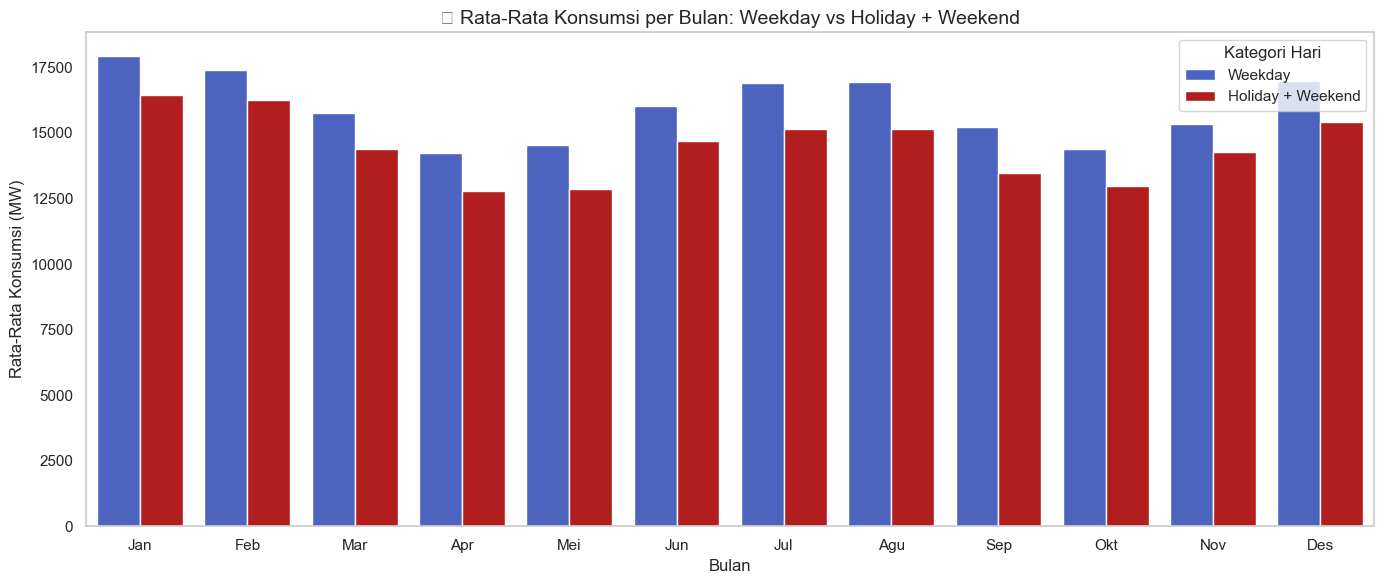

In [84]:
# Pastikan data sudah siap
daily_df['Month'] = daily_df['Date'].dt.month
daily_df['is_weekend'] = daily_df['Date'].dt.dayofweek.isin([5, 6])
daily_df['is_effective_holiday'] = daily_df['is_holiday'] | daily_df['is_weekend']

monthly_grouped = daily_df.groupby(['Month', 'is_effective_holiday'])['AEP_MW'].mean().reset_index()
monthly_grouped['Kategori'] = monthly_grouped['is_effective_holiday'].map({False: 'Weekday', True: 'Holiday + Weekend'})

# Warna custom
custom_palette = [ '#3A59D1','#CB0404']

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=monthly_grouped, x='Month', y='AEP_MW', hue='Kategori', palette=custom_palette)

plt.title("📅 Rata-Rata Konsumsi per Bulan: Weekday vs Holiday + Weekend", fontsize=14)
plt.xlabel("Bulan")
plt.ylabel("Rata-Rata Konsumsi (MW)")
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 'Jul', 'Agu', 'Sep', 'Okt', 'Nov', 'Des'])
plt.legend(title='Kategori Hari')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Htung rata-rata konsumsi per nama hari libur
libur_agg = daily_df[daily_df['is_holiday'] == True].groupby('Holiday')['AEP_MW'].mean().sort_values(ascending=False)
print(libur_agg)

Holiday
Martin Luther King, Jr. Day    18071.032738
Washington's Birthday          17492.226190
Valentine’s Day                17230.068452
Juneteenth                     15979.502976
Thanksgiving Eve               15677.901786
New Year’s Eve                 15600.610119
New Year's Day                 15204.318452
Veterans Day                   14911.613095
Christmas Eve                  14657.172619
Columbus Day                   14367.625000
4th of July                    14259.568452
Christmas Day                  14167.270833
Labor Day                      14079.820513
Labor Day Weekend              13990.312500
Memorial Day                   13770.360119
Thanksgiving Day               13710.699405
Western Easter                 12509.020833
Eastern Easter                 12424.252976
Name: AEP_MW, dtype: float64


In [86]:
# Buat data holiday_stats dulu
holiday_df = daily_df[daily_df['is_holiday'] == True].copy()
holiday_df['Year'] = holiday_df['Date'].dt.year

# Rata-rata konsumsi per libur
avg_per_holiday = holiday_df.groupby('Holiday')['AEP_MW'].mean().sort_values(ascending=False).reset_index()

# Deviasi konsumsi per libur
holiday_variance = holiday_df.groupby('Holiday')['AEP_MW'].std().sort_values(ascending=False).reset_index()
holiday_variance.rename(columns={'AEP_MW': 'STD_Deviation'}, inplace=True)

# Gabungkan ke dalam 1 dataframe
holiday_stats = avg_per_holiday.merge(holiday_variance, on='Holiday')

C:\Users\71485\AppData\Local\Temp\ipykernel_11216\674026760.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_stats.sort_values(by='AEP_MW', ascending=False),


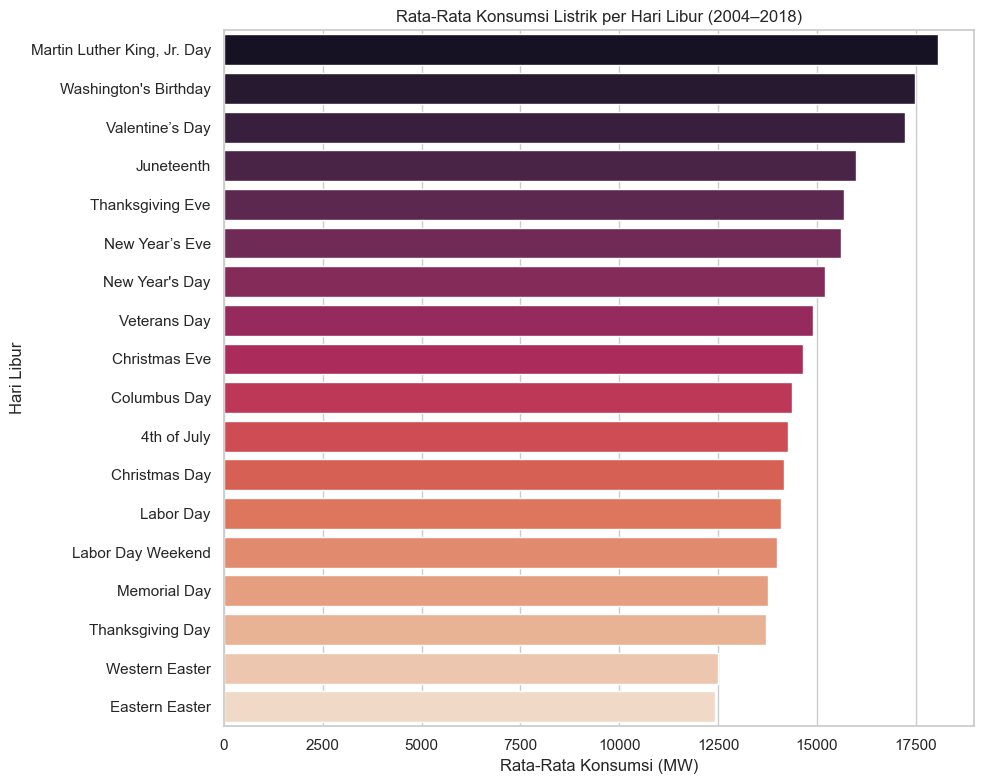

In [103]:
# Grafik 1: Rata-rata konsumsi per hari libur
plt.figure(figsize=(10, 8))
sns.barplot(data=holiday_stats.sort_values(by='AEP_MW', ascending=False),
            y='Holiday', x='AEP_MW', palette='rocket')

plt.title("Rata-Rata Konsumsi Listrik per Hari Libur (2004–2018)")
plt.xlabel("Rata-Rata Konsumsi (MW)")
plt.ylabel("Hari Libur")
plt.tight_layout()
plt.show()

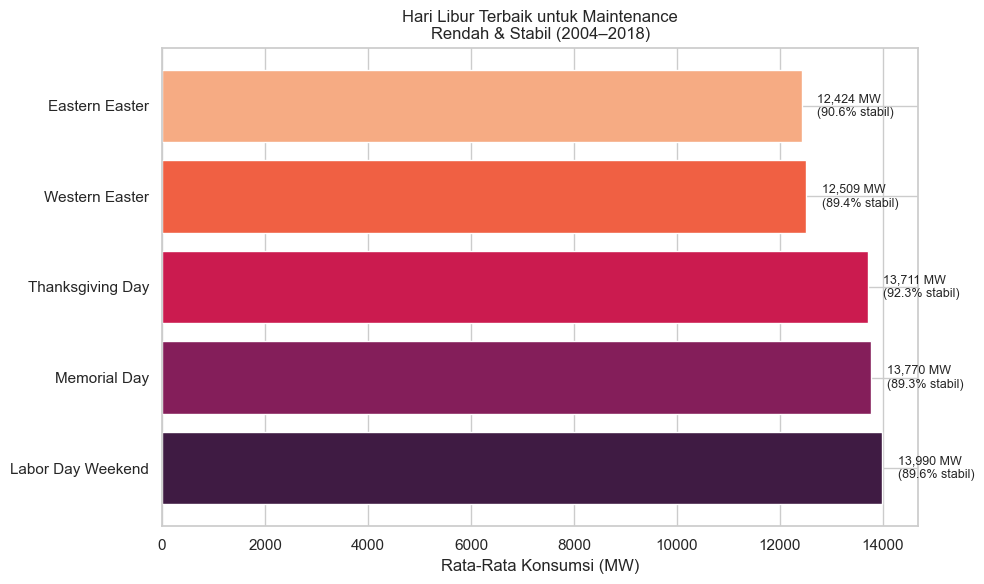

In [108]:
# Ambil 5 hari libur konsumsi terendah
lowest_5 = holiday_stats.sort_values(by='AEP_MW').head(5).copy()

# Hitung % stabilitas
lowest_5['Stability'] = 100 - (lowest_5['STD_Deviation'] / lowest_5['AEP_MW'] * 100)

# Urutkan supaya konsumsi terendah di atas
lowest_5 = lowest_5.sort_values(by='AEP_MW', ascending=False)

# Buat gradasi warna dari terang ke gelap
colors = sns.color_palette("rocket", len(lowest_5))

# Plot horizontal bar
plt.figure(figsize=(10, 6))
bars = plt.barh(lowest_5['Holiday'], lowest_5['AEP_MW'], color=colors)

# Tambah label di ujung bar
for i, bar in enumerate(bars):
    val = lowest_5['AEP_MW'].values[i]
    stab = lowest_5['Stability'].values[i]
    plt.text(bar.get_width() + 300, bar.get_y() + bar.get_height()/2,
             f"{val:,.0f} MW\n({stab:.1f}% stabil)", va='center', fontsize=9)

# Visual styling
plt.xlabel("Rata-Rata Konsumsi (MW)")
plt.title("Hari Libur Terbaik untuk Maintenance\nRendah & Stabil (2004–2018)")
plt.tight_layout()
plt.show()

C:\Users\71485\AppData\Local\Temp\ipykernel_11216\888255239.py:67: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


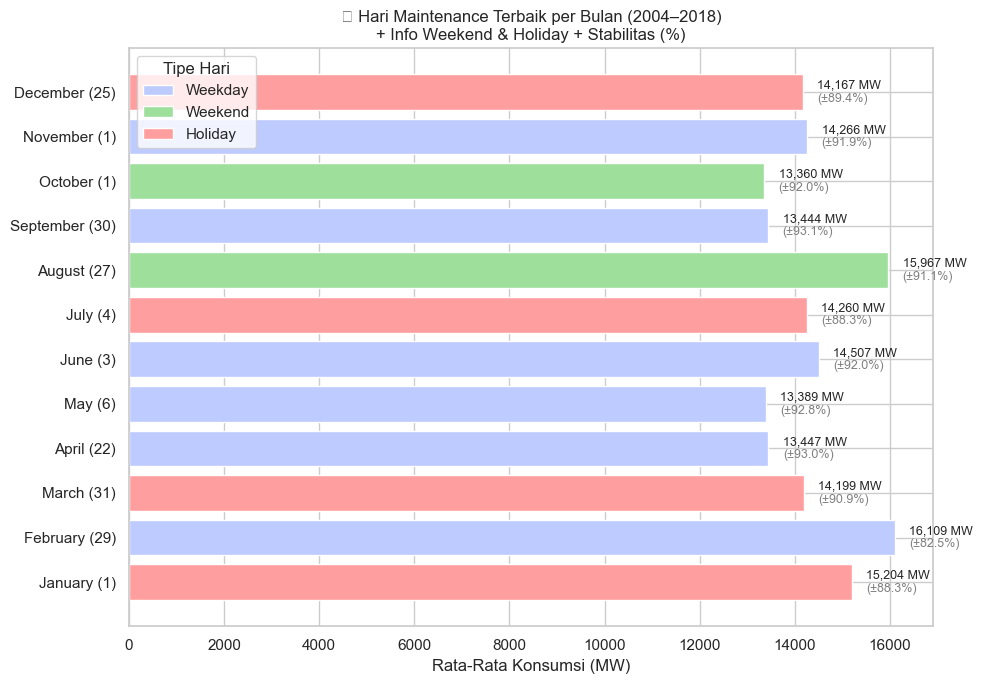

In [122]:
from matplotlib.patches import Patch

# Gunakan tahun kabisat agar 29 Februari valid
maintenance_dates = pd.to_datetime({
    'year': 2016,
    'month': best_maintenance_days['Month'],
    'day': best_maintenance_days['Day']
})

# Tentukan jenis hari
maintenance_labels = []
for dt in maintenance_dates:
    is_weekend = dt.weekday() >= 5
    is_holiday = not holidays[
        (holidays['Date'].dt.month == dt.month) &
        (holidays['Date'].dt.day == dt.day)
    ].empty
    if is_holiday:
        maintenance_labels.append("Holiday")
    elif is_weekend:
        maintenance_labels.append("Weekend")
    else:
        maintenance_labels.append("Weekday")

# Tambah ke dataframe
best_maintenance_days['DayType'] = maintenance_labels
best_maintenance_days['Label'] = best_maintenance_days.apply(
    lambda row: f"{calendar.month_name[int(row['Month'])]} ({int(row['Day'])})", axis=1
)
best_maintenance_days = best_maintenance_days.sort_values(by='Month')

# Hitung stabilitas (%)
best_maintenance_days['Stability_Pct'] = 0.0
for i, row in best_maintenance_days.iterrows():
    month, day = row['Month'], row['Day']
    day_consumptions = daily_df[(daily_df['Date'].dt.month == month) &
                                (daily_df['Date'].dt.day == day)]
    if not day_consumptions.empty:
        mean_val = day_consumptions['AEP_MW'].mean()
        std_val = day_consumptions['AEP_MW'].std()
        stability = 100 * (1 - (std_val / mean_val))
        best_maintenance_days.at[i, 'Stability_Pct'] = round(stability, 1)

# Warna gradasi berdasarkan jenis hari
palette = {
    "Weekday": "#BECBFF",
    "Weekend": "#9EDF9C",
    "Holiday": "#FF9E9E"
}
colors = best_maintenance_days['DayType'].map(palette)

# Plot
plt.figure(figsize=(10, 7))
bars = plt.barh(best_maintenance_days['Label'], best_maintenance_days['AEP_MW'], color=colors)

for bar, val, stab in zip(bars, best_maintenance_days['AEP_MW'], best_maintenance_days['Stability_Pct']):
    y = bar.get_y() + bar.get_height() / 2
    plt.text(bar.get_width() + 300, y + 0.15, f"{val:,.0f} MW", va='center', fontsize=9)
    plt.text(bar.get_width() + 300, y - 0.15, f"(±{stab:.1f}%)", va='center', fontsize=9, color='gray')

# Legend
legend_elements = [Patch(facecolor=palette[k], label=k) for k in palette]
plt.legend(handles=legend_elements, title='Tipe Hari')

plt.xlabel("Rata-Rata Konsumsi (MW)")
plt.title("📅 Hari Maintenance Terbaik per Bulan (2004–2018)\n+ Info Weekend & Holiday + Stabilitas (%)")
plt.tight_layout()
plt.show()

In [119]:
# Ambil 1 hari konsumsi tertinggi per bulan dari seluruh tahun (2004–2018)
monthly_peak_days = daily_df.groupby(['Month', 'Day'])['AEP_MW'].mean().reset_index()

# Ambil hari tertinggi tiap bulan
best_distribution_days = monthly_peak_days.loc[
    monthly_peak_days.groupby('Month')['AEP_MW'].idxmax()
].sort_values(by='Month')

C:\Users\71485\AppData\Local\Temp\ipykernel_11216\313415235.py:67: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


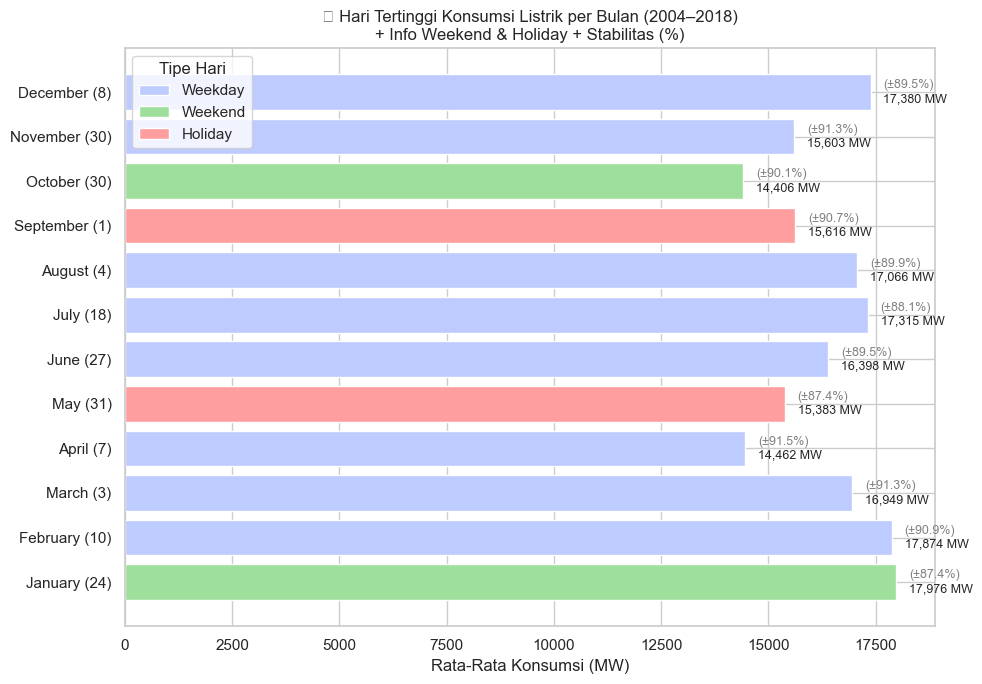

In [126]:
# Buat label dan tipe hari
peak_dates = pd.to_datetime({
    'year': 2016,
    'month': best_distribution_days['Month'],
    'day': best_distribution_days['Day']
})

# Klasifikasi tipe hari
day_types = []
for dt in peak_dates:
    is_weekend = dt.weekday() >= 5
    is_holiday = not holidays[
        (holidays['Date'].dt.month == dt.month) &
        (holidays['Date'].dt.day == dt.day)
    ].empty
    if is_holiday:
        day_types.append("Holiday")
    elif is_weekend:
        day_types.append("Weekend")
    else:
        day_types.append("Weekday")

best_distribution_days['DayType'] = day_types
best_distribution_days['Label'] = best_distribution_days.apply(
    lambda row: f"{calendar.month_name[int(row['Month'])]} ({int(row['Day'])})", axis=1
)

# Hitung stabilitas (%)
best_distribution_days['Stability_Pct'] = 0.0
for i, row in best_distribution_days.iterrows():
    month, day = row['Month'], row['Day']
    values = daily_df[(daily_df['Date'].dt.month == month) & (daily_df['Date'].dt.day == day)]
    if not values.empty:
        mean_val = values['AEP_MW'].mean()
        std_val = values['AEP_MW'].std()
        stability = 100 * (1 - (std_val / mean_val))
        best_distribution_days.at[i, 'Stability_Pct'] = round(stability, 1)

# Urutkan dari Januari (1) ke Desember (12)
best_distribution_days = best_distribution_days.sort_values(by='Month', ascending=False)

# Warna per tipe hari
palette = {
    "Weekday": "#BECBFF",
    "Weekend": "#9EDF9C",
    "Holiday": "#FF9E9E"
}
colors = best_distribution_days['DayType'].map(palette)

# Plot
plt.figure(figsize=(10, 7))
bars = plt.barh(best_distribution_days['Label'], best_distribution_days['AEP_MW'], color=colors)
plt.gca().invert_yaxis()  # Januari di bawah

# Tambahkan teks konsumsi + stabilitas
for bar, val, stab in zip(bars, best_distribution_days['AEP_MW'], best_distribution_days['Stability_Pct']):
    y = bar.get_y() + bar.get_height() / 2
    plt.text(bar.get_width() + 300, y + 0.15, f"{val:,.0f} MW", va='center', fontsize=9)
    plt.text(bar.get_width() + 300, y - 0.15, f"(±{stab:.1f}%)", va='center', fontsize=9, color='gray')

# Legend
legend_elements = [Patch(facecolor=palette[k], label=k) for k in palette]
plt.legend(handles=legend_elements, title='Tipe Hari')

plt.xlabel("Rata-Rata Konsumsi (MW)")
plt.title("⚡ Hari Tertinggi Konsumsi Listrik per Bulan (2004–2018)\n+ Info Weekend & Holiday + Stabilitas (%)")
plt.tight_layout()
plt.show()